In [1]:
import sys, os
sys.path.insert(0, os.path.join("..", "..", ".."))

# Cross-Validation on a grid

Continuing to work with the Rosser et al. paper, we also want to cross validate the grid based "prospective hotspotting".

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import descartes
import shelve

import open_cp.sources.chicago
import open_cp.geometry
import open_cp.prohotspot
import open_cp.predictors

In [3]:
data_path = os.path.join("/media", "disk", "Data")
#data_path = os.path.join("..", "..", "..", "..", "..", "..", "Data")
open_cp.sources.chicago.set_data_directory(data_path)
south_side = open_cp.sources.chicago.get_side("South")

In [4]:
grid = open_cp.data.Grid(xsize=150, ysize=150, xoffset=0, yoffset=0)
grid = open_cp.geometry.mask_grid_by_intersection(south_side, grid)

In [5]:
filename = open_cp.sources.chicago.get_default_filename()
timed_points = open_cp.sources.chicago.load(filename, ["BURGLARY"])
timed_points.number_data_points, timed_points.time_range

(13970,
 (numpy.datetime64('2016-05-04T05:30:00.000'),
  numpy.datetime64('2017-05-03T23:48:00.000')))

In [6]:
timed_points = open_cp.geometry.intersect_timed_points(timed_points, south_side)
timed_points.number_data_points

1985

### Use old data instead

In [7]:
filename = os.path.join(data_path, "chicago_all_old.csv")
timed_points = open_cp.sources.chicago.load(filename, ["BURGLARY"], type="all")
timed_points.number_data_points, timed_points.time_range

(326540,
 (numpy.datetime64('2001-01-01T00:01:00.000'),
  numpy.datetime64('2014-05-24T22:30:00.000')))

In [8]:
timed_points = open_cp.geometry.intersect_timed_points(timed_points, south_side)
timed_points.number_data_points

46920

# What do Rosser et al do?

They seem to use a "hybrid" approach, which we have (fortuitously) implemented as `ProspectiveHotSpotContinuous`.  That is, they use a continuous KDE method, with both a space and time component, and then convert this to a grid as a final step.

The exact formula used is
$$ \lambda(t,s) = \sum_{i : t_i<t} f(\|s-s_i\|) g(t-t_i) $$
where
$$ f(\Delta s) = \begin{cases} \frac{h_S - \Delta s}{h_s^2} & :\text{if } \Delta s \leq h_S, \\ 0 &:\text{otherwise.}
\end{cases} 
\qquad
g(\Delta t) = \frac{1}{h_T} \exp\Big( -\frac{\Delta t}{h_T} \Big). $$
Notice that this is _not normalised_ because when converting from two dimensions to a (positive) number using the Euclidean norm $\|\cdot\|$ we map the infinitesimal annulus $r \leq \sqrt{x^2+y^2} \leq r+dr$ to the interval $[r, r+dr]$; the former has area $\pi((r+dr)^2 - r^2) = 2\pi r dr$ while the latter has length $dr$.

However, be this as it may, let us continue to try to replicate their findings.

In [9]:
predictor = open_cp.prohotspot.ProspectiveHotSpotContinuous(grid_size=150, time_unit=np.timedelta64(1, "D"))
predictor.data = timed_points[timed_points.timestamps >= np.datetime64("2013-01-01")]

In [10]:
class OurWeight():
    def __init__(self):
        self.time_bandwidth = 1000
        self.space_bandwidth = 10
    
    def __call__(self, dt, dd):
        kt = np.exp(-dt / self.time_bandwidth) / self.time_bandwidth
        dd = np.atleast_1d(np.asarray(dd))
        ks = (self.space_bandwidth - dd) / (self.space_bandwidth * self.space_bandwidth)
        mask = dd > self.space_bandwidth
        ks[mask] = 0
        return kt * ks

In [11]:
predictor.weight = OurWeight()

In [12]:
tend = np.datetime64("2013-01-01") + np.timedelta64(180, "D")
prediction = predictor.predict(tend, tend)
grid_pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(prediction, grid)
grid_pred.mask_with(grid)

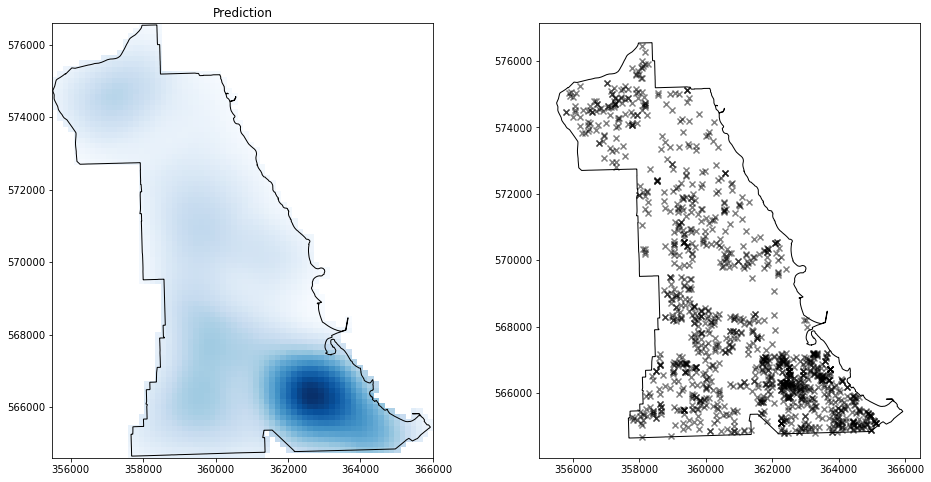

In [13]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
ax[0].pcolormesh(*grid_pred.mesh_data(), grid_pred.intensity_matrix, cmap="Blues")
ax[0].set_title("Prediction")

points = predictor.data.events_before(tend)
ax[1].scatter(points.xcoords, points.ycoords, marker="x", color="black", alpha=0.5)
None

In [15]:
grid_pred.risk([364000,0], [566000,100])

TypeError: unsupported operand type(s) for -: 'list' and 'int'

## Scoring

For now, we'll just use the grid as is.  Later we will intersect it with the network.

In [17]:
def log_likelihood(grid_pred, timed_points):
    logli = 0
    for x, y in zip(timed_points.xcoords, timed_points.ycoords):
        risk = grid_pred.risk(x, y)
        if risk < 1e-30:
            logli -= 27.6
        else:
            logli += np.log(risk)
    return logli

In [18]:
tstart = np.datetime64("2013-01-01")
tend = np.datetime64("2013-01-01") + np.timedelta64(180, "D")

def score(predictor):
    out = 0
    grids = dict()
    for day in range(60):
        start = tend + np.timedelta64(1, "D") * day
        end = tend + np.timedelta64(1, "D") * (day + 1)
        prediction = predictor.predict(start, start)
        grid_pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(prediction, grid)
        mask = (predictor.data.timestamps > start) & (predictor.data.timestamps <= end)
        timed_points = predictor.data[mask]
        out += log_likelihood(grid_pred, timed_points)
        grids[start] = grid_pred
    return out, grids

In [ ]:
time_lengths = list(range(5,100,5))
space_lengths = list(range(50, 2000, 50))
predictor = open_cp.prohotspot.ProspectiveHotSpotContinuous(grid_size=150, time_unit=np.timedelta64(1, "D"))
predictor.data = timed_points[timed_points.timestamps >= np.datetime64("2013-01-01")]

results = dict()
store = shelve.open("grid_risks")

for sl in space_lengths:
    for tl in time_lengths:
        predictor.weight = OurWeight()
        predictor.weight.space_bandwidth = sl
        predictor.weight.time_bandwidth = tl
        key = (sl, tl)
        results[key], grids = score(predictor)
        store[str(key)] = grids
        
store.close()